# Flow matching

In this notebook, we will create our own flow matching network, and train it to reproduce the "datasaurus" distribution. 

We will use the simplest form of a flow matching. 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

## The data

The data set stored in the `datasaurus.csv` file can be downloaded from the website of the seminar. Download the file in wherever you run this notebook.

We read the notebook into a numpy array and also rescale the data. 

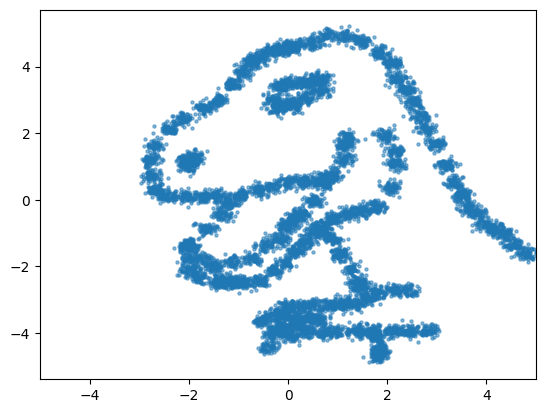

In [2]:
data = np.genfromtxt("datasaurus.csv", delimiter=",", skip_header=1)
data = data/10 - 5

f=plt.scatter(data[:,0], data[:,1], s=5, alpha=0.5)
f=plt.xlim(-5, 5)
f=plt.xlim(-5, 5)

## The model

The flow matching model is composed of a single MLP network that will take in the samples $x_t \in \mathbb{R}^2$ concatenated with the time variable $t \in [0, 1]$, and outputs a velocity vector $v_\theta(x_t, t) \in \mathbb{R}^2$.

The samples x_t are computed by linearly interpolating between samples $x_0$ (sampled from the base distribution) and $x_1$ (sampled from the data distribution):

$$
x_t = (1-t) x_0 + t x_1.
$$

For sampling, we will implement a basic ODE solver. We will approximate the trajectory of a sample from point $x_0$ into point $x_1$ by moving the point along its velocity in a series of small time steps of $dt$. At each time step, we will approximate the "midpoint" velocity, that is, a velocity that we would expect in the middle of the step (at $t + dt/2$). In each step, we go from point $x_t$ to point $x_{t+dt}$ as follows,

$$
\begin{aligned}
v_t & = v_\theta(x_t, t) \\
\hat{x}_\text{midpoint} & = x_t + v_t \times dt/2 \\
\hat{v}_\text{midpoint} & = v_\theta(\hat{x}_\text{midpoint}, t+dt/2) \\
x_{t+dt} & = x_t + \hat{v}_\text{midpoint} \times dt.
\end{aligned}
$$

We will make these steps all the way from $x_0$ to $x_1$, where the intial points are sampled from the base distribution $x_0 \sim \text{Normal}(0, I)$.

In [3]:
class FlowMatching(keras.Model):
    def __init__(self, n_units, n_layers, dim=2):
        """ Initiate the flow matching model object

        Parameters
        ----------
        n_units: int
            Number of units per each layer of the velocity MLP
        n_layers: int
            Number of layers of the velocity MLP
        dim: int
            Number of output dimensions (by default 2 because the datasaurus lives in 2D)
        """
        super(FlowMatching, self).__init__()
        self.dim = dim
        self.velocity = keras.Sequential(
            [keras.layers.Dense(n_units, activation="elu") for _ in range(n_layers)]
            )
        self.velocity.add(keras.layers.Dense(dim))

    def call(self, inputs):
        """ Call the velocity vector

        Parameters
        ----------
        inputs: dict
            x_0: samples from the base distribution
            x_1: samples from the data distribution
            t:   samples of the time variable between [0, 1]


        Returns the velocity vector
        """
        x_0, x_1, t = inputs.values()
        x_t = (1-t)*x_0 + t*x_1
        x = keras.ops.concatenate([x_t, t], axis=-1)
        return self.velocity(x)

    def step(self, x, t, dt):
        """ Make one step using the midpoint ODE solver

        Parameters
        ----------
        x: tensor/array (batch_size, dim)
            Samples of the variable x_t
        t: tuple/array (batch_size,)
            Samples of the time variable between [0, 1]
        dt: float
            The size of the time step

        Returns: tensor/array (batch_size, dim)
            Samples of the variable x_{t+dt}
        """

        t_start = np.zeros_like(x) + t
        input_start = keras.ops.concatenate([x, t_start], axis=-1)
        v = self.velocity(input_start)
        x_mid = x + v * dt / 2

        t_mid = t_start + dt / 2
        input_mid = keras.ops.concatenate([x_mid, t_mid], axis=-1)
        v = self.velocity(input_mid)
        x_end = x + v * dt

        return x_end

    def run(self, x, steps):
        """ Run the ODE solver from t=0 to t=1

        Parameters
        ----------
        x: tensor/array (batch_size, dim)
            Samples from the base distribution, x_0
        steps: int
            Number of steps to make between t=0 and t=1
        
        Returns: tensor/array (batch_size, dim)
            Samples x_1 ~ p_1
        """
        time = np.linspace(0, 1, steps+1)
        output = []
        output.append(x)
        for i in range(steps):
            x = self.step(x, time[i], time[i+1]-time[i])
            output.append(x)
        
        return output

    def sample(self, n_samples, steps):
        """ Sample from the learned distribution

        Parameters
        ----------
        n_samples: int
            Number of samples to take
        steps: int
            Number of steps to make between t=0 and t=1 in the ODE

        Returns array (batch_size, steps+1, dim)
            Samples of x_t ~ p_t
        """
        x_0 = np.random.normal(size=(n_samples, self.dim))
        x_1 = self.run(x_0, steps)
        
        return np.array(x_1).swapaxes(0, 1)

One we defined our model class, we can instantiate a new flow matching model object.

In [4]:
flow = FlowMatching(n_units=64, n_layers=8)

## Training

For training we will take a slightly different approach than in the normalizing flow exercise. Here we will make a new dataset object that will inherit from the `PyDataset` class. This allows us to get random coupling between the base and the data distribution, as well as the random time variable

Whenever we want to get a batch of samples, we will simply take a random subset of rows from the datasaurus dataset. This will be our samples $x_t$. Samples from the base distribution will be generated by drawing from a bi-variate normal $x_0 \sim \text{Normal}(0, I)$. Lastly, the time variable will be drawn from a uniform distribution $t \sim \text{Uniform}(0, 1)$.

Finally, the target velocity is calculated simply as $v = x_1 - x_0$.

In [5]:
class DataSet(keras.utils.PyDataset):
    def __init__(self, batch_size, n_batches, data):
        super().__init__()
        self.n_batches=n_batches
        self.batch_size = batch_size
        self.data = data
    
    @property
    def num_batches(self):
        return self.n_batches

    def __getitem__(self, index):
        data = self.data
        rows = np.random.choice(data.shape[0], size=self.batch_size, replace=True)
        data = data[rows]

        base = np.random.normal(size=data.shape)
        
        t = np.random.uniform(low=0, high=1, size=data.shape[0])
        t = np.repeat(t[:,np.newaxis], repeats=data.shape[1], axis=1)

        target = data - base
        return dict(x_0=base, x_1=data, t=t), target

We configure the dataset such that every time we sample from it, we will draw a batch of 512 samples.

In [6]:
epochs=20
batches=1000
batch_size=512

dataset=DataSet(batch_size=batch_size, n_batches=epochs*batches, data=data)

Next, we define our learning rate schedule and optimizer. We will use a Cosine Decay and Adam optimizer.

In [7]:
schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.01, decay_steps=epochs*batches)
optimizer = keras.optimizers.Adam(schedule, global_clipnorm=1.0)

Now we can compile the model: we supply the optimizer and add a mean square error loss. This loss will be used to regress the velocity network $v_\theta$ on the target velocities $x_1 - x_0$.

In [8]:
flow.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError()
)

Because we compiled the model together with an optimizer and a loss, and because we set up our data set object such that it can easily be used on our network, we can simply fit our model with the `.fit` method - no manual gradient calculation, no manual fitting loop.

In [9]:
history=flow.fit(x=dataset, epochs=epochs, steps_per_epoch=batches)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3.6111
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.3610
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.3295
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.3245
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.3200
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.3108
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.2899
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.2719
Epoch 9/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.2796
Epoch 10/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.2862
Epoch 11/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.2628
Epoch 12/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.2722
Epoch 13/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.2579
Epoch 14/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.2366
Epoch 15/20
1000/1000 ━━━━━━━

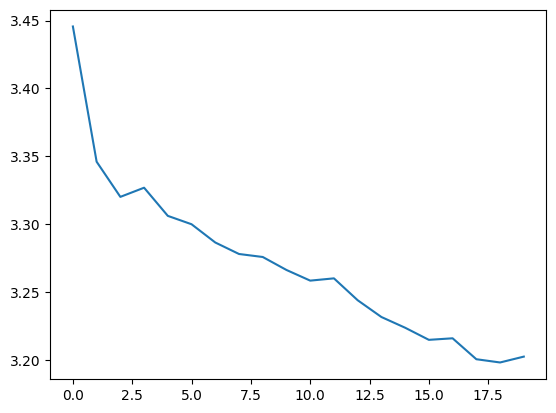

In [10]:
f=plt.plot(history.history["loss"])

Now that we fitted the model, let's see the samples it generates!

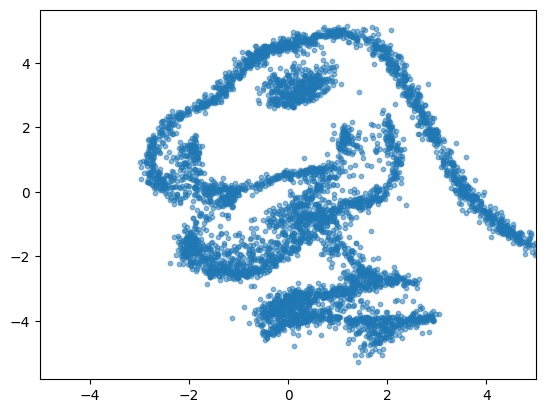

In [11]:
n_samples=5000
x = flow.sample(n_samples=n_samples, steps=100)
# -1 gets the samples at the last time step, e.i, t=1
f=plt.scatter(x[:, -1, 0], x[:, -1, 1], s=10, alpha=0.5)
f=plt.xlim(-5, 5)
f=plt.xlim(-5, 5)

# Further exercise

The accuracy of the approximation is generally driven by how expressive the velocity network is, how well it is trained, but also by the accuracy of the integrator. Play around with the network complexity of the flow matching model, simulation budget, and the steps taken during the ODE solver to see how will it affect your ability to generate the datasaurus distribution.